# This notebook is used to model TMAX data 
* Uses polynomial transformations
* Will include 0th through 5th degree polynomials
 * 0th is horizontal based model
 * 1st is linear regression based model
 * 2nd-5th are polynomial models

Will use three methods of evaluation to find the model with the best fit
* Mean Absolute Error - Optimized by lowest value
* Root Mean Squared Error - Optimized by lowest value
* R2 Score - Optimized by highest value

This notebook may be downloaded and ran as a slide using:
* jupyter nbconvert Polynomial_model_TMAX_fitting.ipynb --to slides --post serve

# Importing all the dependencies that will be used in this notebook

In [1]:
# importing dependencies
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

# For model building
from sklearn.model_selection import train_test_split

# Models
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Evaluations
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

# Loading of the data
* Will only use year 2013-2017 of NiceRideMN Data (minimal expansion years)

In [2]:
# Load in the data
weather = pd.read_csv("~/Projects/NiceRide/Weather_data/01012010_12312017.csv") # Weather data
#weather = pd.read_csv('/home/gilmore/NiceRideMN/Weather_data/01012010_12312017.csv') # weather alt

temp = []
for x in [2013 + x for x in range(5)] :
    x = pd.read_csv("~/Projects/NiceRide/Nice_Ride_data/"+str(x)+"/NiceRide_trip_history_"+str(x)+".csv")
    #x = pd.read_csv('/home/gilmore/NiceRideMN/Nice_Ride_data/'+str(x)+'/NiceRide_trip_history_'+str(x)+'.csv')
    temp.append(x)
    nr = pd.concat(temp)

## Changing the datetime objects to datetime variables

In [3]:
weather['DATE'] = weather['DATE'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))

nr['Start_date'] = nr['Start_date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
nr['End_date'] = nr['End_date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

## Preparing the data to be used for the model
* Using datetime variable rides will be grouped by:
 * Daily count.

In [4]:
# Resampling our NR data so it takes the start date and Total duration, 
# returns a count of rides per day 'daily_totals'

daily_totals = nr[['Start_date', 'duration']].resample('D', on='Start_date').count()
daily_totals = daily_totals.drop('Start_date', axis=1)
daily_totals = daily_totals.reset_index()
daily_totals = daily_totals.rename(index=str, columns={"duration": "daily_count",'Start_date':'DATE'})

## Correcting missing data in the weather dataframe
* From 2010-2013 There isn't TAVG this will be ameliorated by using the mean of TMIN and TMAX

In [5]:
# Changing TAVG-NAN values to the mean of the TMAX and TMIN
weather = weather.fillna(value={'TAVG': weather[weather.TAVG.isna()][['TMAX', 'TMIN']]
                                .agg("mean", axis="columns")})

## Dropping columns that won't be used in the analysis.

In [6]:
weather = weather.drop(['STATION', 'NAME'], axis=1)

## Now though our data is corrected for the analysis it will be merged together

In [7]:
temp = weather.merge(daily_totals, how='outer',on='DATE')
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2922 entries, 0 to 2921
Data columns (total 9 columns):
DATE           2922 non-null datetime64[ns]
AWND           2922 non-null float64
PRCP           2922 non-null float64
SNOW           2922 non-null float64
SNWD           2922 non-null int64
TAVG           2922 non-null float64
TMAX           2922 non-null int64
TMIN           2922 non-null int64
daily_count    1761 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 228.3 KB


In [8]:
temp.head()

,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,daily_count
0,2010-01-01,8.95,0.0,0.0,9,-1.5,6,-9,NaN
1,2010-01-02,4.03,0.0,0.0,9,-7.0,1,-15,NaN
2,2010-01-03,2.91,0.0,0.0,9,-3.5,7,-14,NaN
3,2010-01-04,5.59,0.0,0.0,9,-1.5,7,-10,NaN
4,2010-01-05,3.13,0.0,0.0,9,0.5,10,-9,NaN


# daily_count has NaN value for when we didn't have any rides
# fill these observations with 0's instead

In [9]:
features = temp.fillna(value=0,axis=0) 
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2922 entries, 0 to 2921
Data columns (total 9 columns):
DATE           2922 non-null datetime64[ns]
AWND           2922 non-null float64
PRCP           2922 non-null float64
SNOW           2922 non-null float64
SNWD           2922 non-null int64
TAVG           2922 non-null float64
TMAX           2922 non-null int64
TMIN           2922 non-null int64
daily_count    2922 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 228.3 KB


# Need to drop all days where there where no rides taken
* This model will only take in days where we have ride data for
* daily_count != 0

In [10]:
features = features[features['daily_count'] != 0].reset_index(drop=True)
# build target (daily_count) data set, and drop unneccesary columns from features
target = features.daily_count.values
features = features.drop(['daily_count', 'DATE'], axis=1)

In [11]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 7 columns):
AWND    1080 non-null float64
PRCP    1080 non-null float64
SNOW    1080 non-null float64
SNWD    1080 non-null int64
TAVG    1080 non-null float64
TMAX    1080 non-null int64
TMIN    1080 non-null int64
dtypes: float64(4), int64(3)
memory usage: 59.1 KB


# Splitting the data for training and testing
* Other numerical feature colummns can be used to see how they perform too
* i.e. TAVG, AWND, 

In [12]:
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features['TMAX'].values.reshape(-1, 1),
                                                    target.reshape(-1,1), 
                                                    test_size=.25, 
                                                    random_state=21)

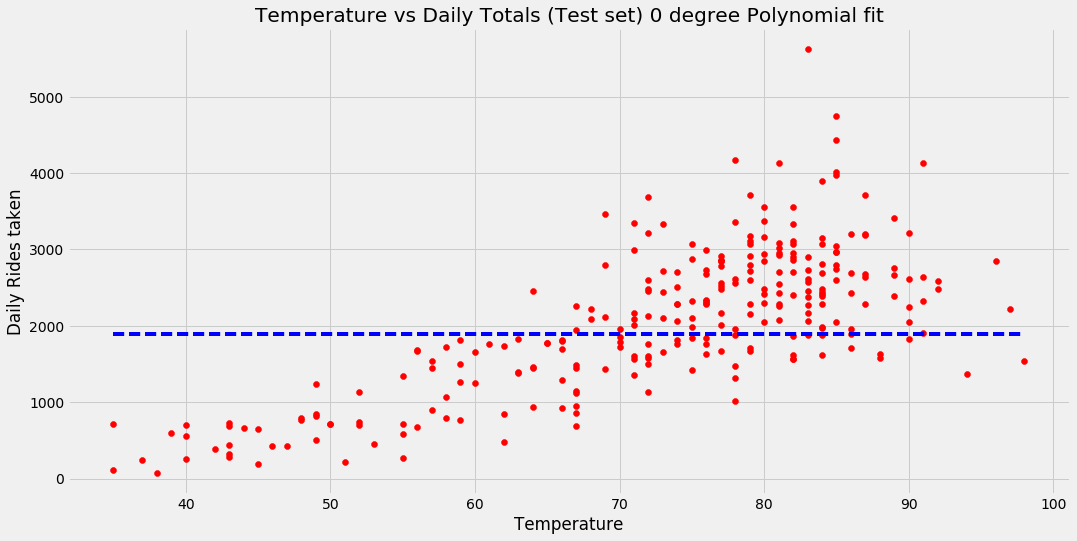

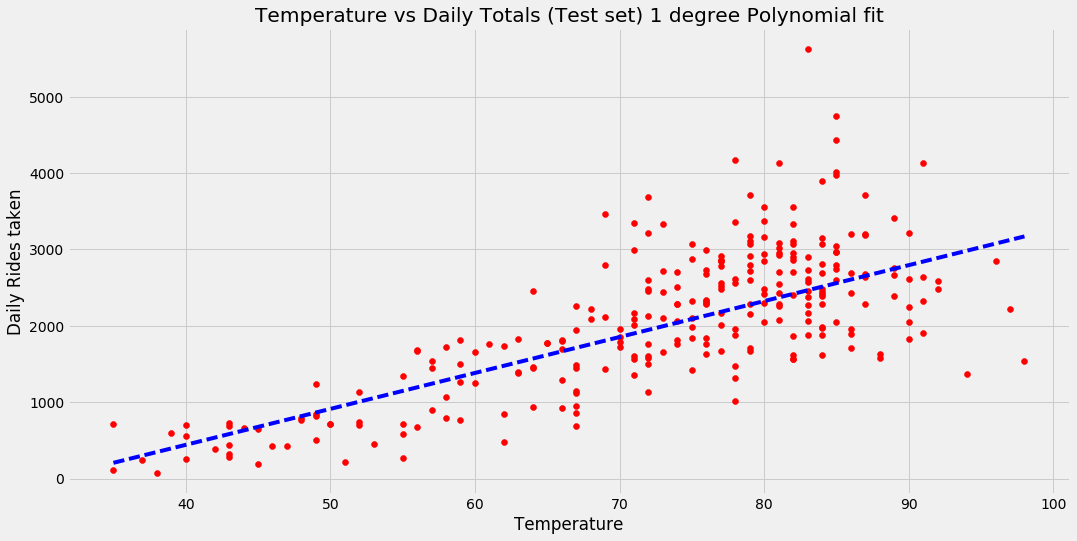

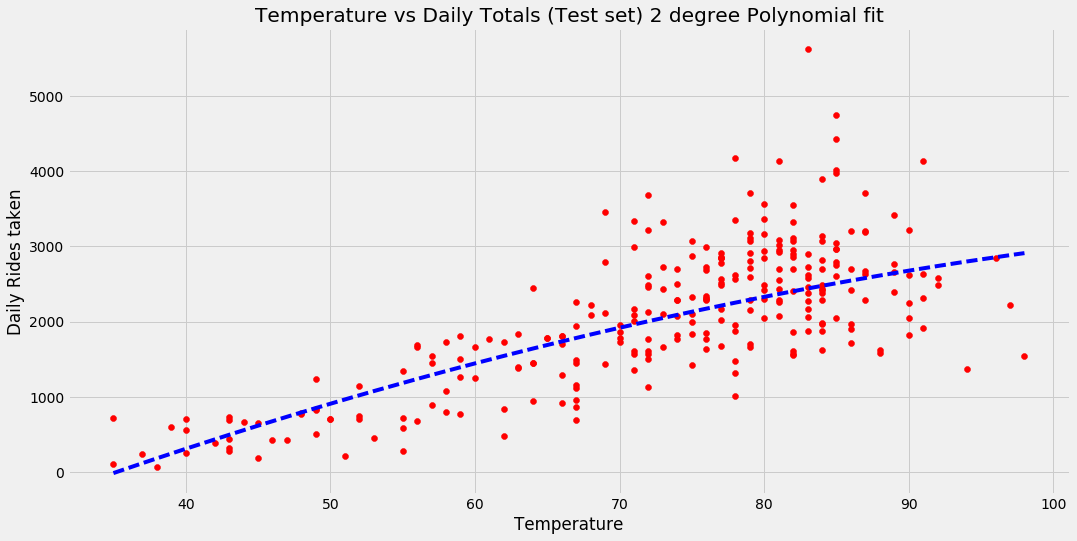

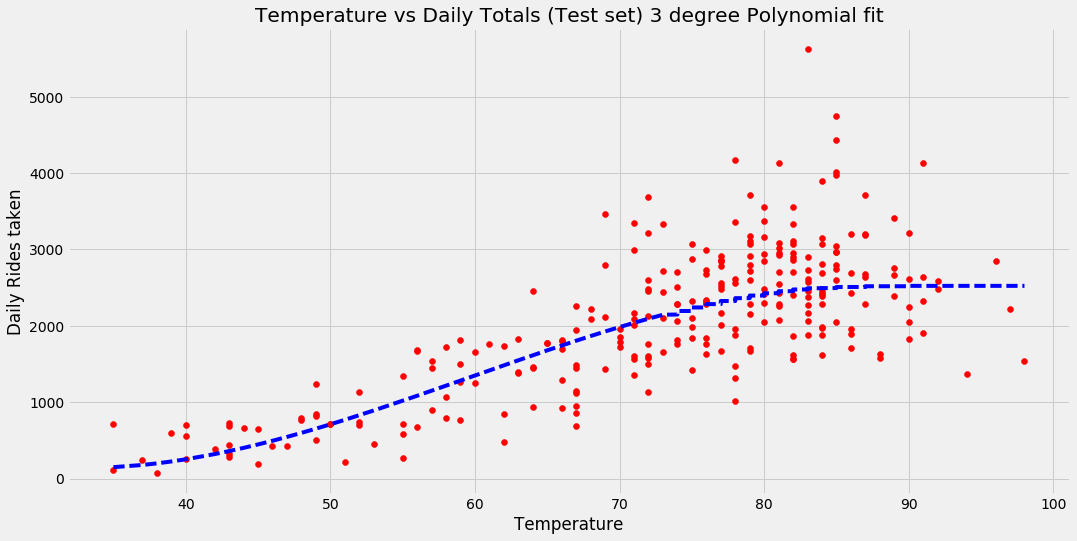

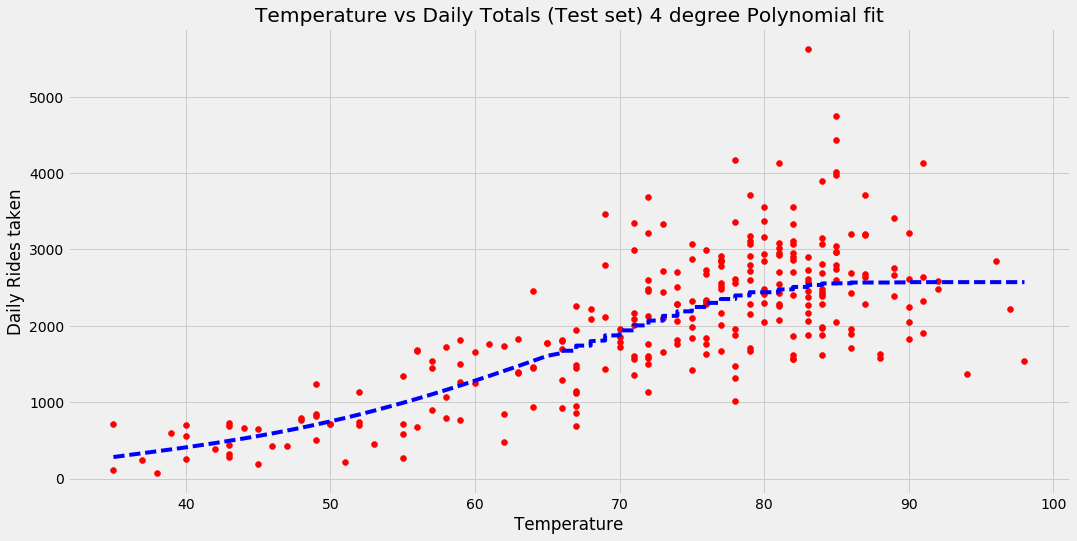

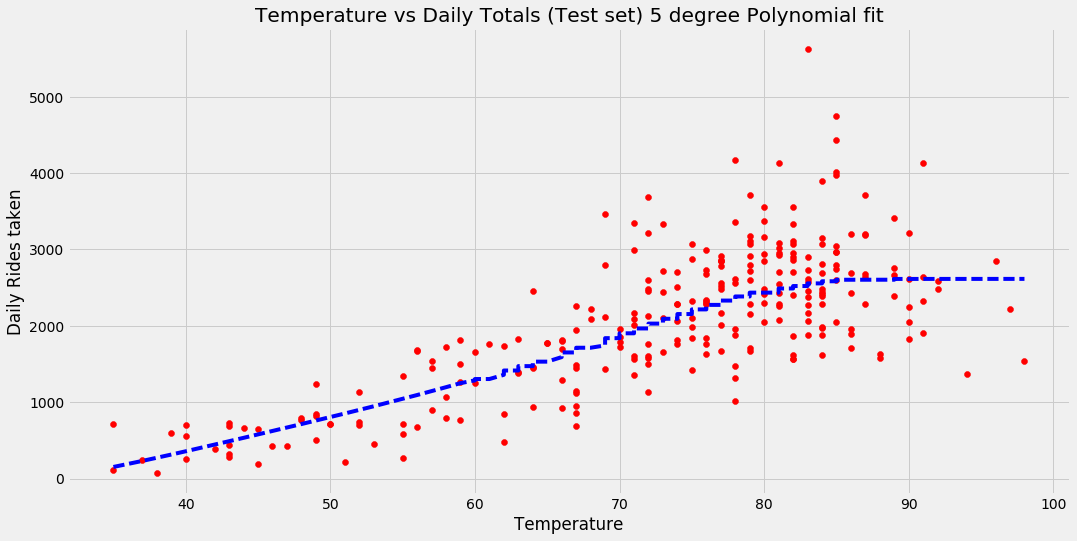

In [13]:
m_absolute_error = []; root_mean_sq_error = []; r_2_score = []
plt.style.use('fivethirtyeight')

for degrees in range(6) :

    # Extracting polynomial features
    poly = PolynomialFeatures(degree=degrees)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)


    # Create regressor using linear regression
    regressor = LinearRegression()

    # Training our model
    regressor.fit(X_train_poly, y_train)

    # Predicting values using our trained model
    y_pred = regressor.predict(X_test_poly)

    # Let's see how well the model does against our test data.
    plt.figure(figsize=[16,8])
    plt.scatter(X_test, y_test, color = 'red')
    plt.plot(sorted(X_test), sorted(y_pred), '--',color = 'blue')
    
    plt.title('Temperature vs Daily Totals (Test set) '+str(degrees)+' degree Polynomial fit')
    plt.xlabel('Temperature')
    plt.ylabel('Daily Rides taken')
    plt.show()

    m_absolute_error.append(mean_absolute_error(y_test, y_pred))
    root_mean_sq_error.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    r_2_score.append(r2_score(y_test, y_pred))

In [14]:
print("\nMean Absolute Error best degree")
print(m_absolute_error.index(sorted(m_absolute_error, reverse=True)[-1]))
print("Mean Absolute Error lowest value")
print(sorted(m_absolute_error, reverse=True)[-1])


Mean Absolute Error best degree
4
Mean Absolute Error lowest value
460.343014195


In [15]:
print("\nRoot Mean Squared Error best degree")
print(root_mean_sq_error.index(sorted(root_mean_sq_error, reverse=True)[-1]))
print("Root Mean Squared Error lowest value")
print(sorted(root_mean_sq_error, reverse=True)[-1])


Root Mean Squared Error best degree
4
Root Mean Squared Error lowest value
616.576451703


In [16]:
print("\nR Squared Score best degree")
print(r_2_score.index(sorted(r_2_score, reverse=True)[0]))
print("R Squared Score, highest value")
print(sorted(r_2_score, reverse=True)[0])


R Squared Score best degree
4
R Squared Score, highest value
0.574521382938


# Polynomial of degree 4 is our best

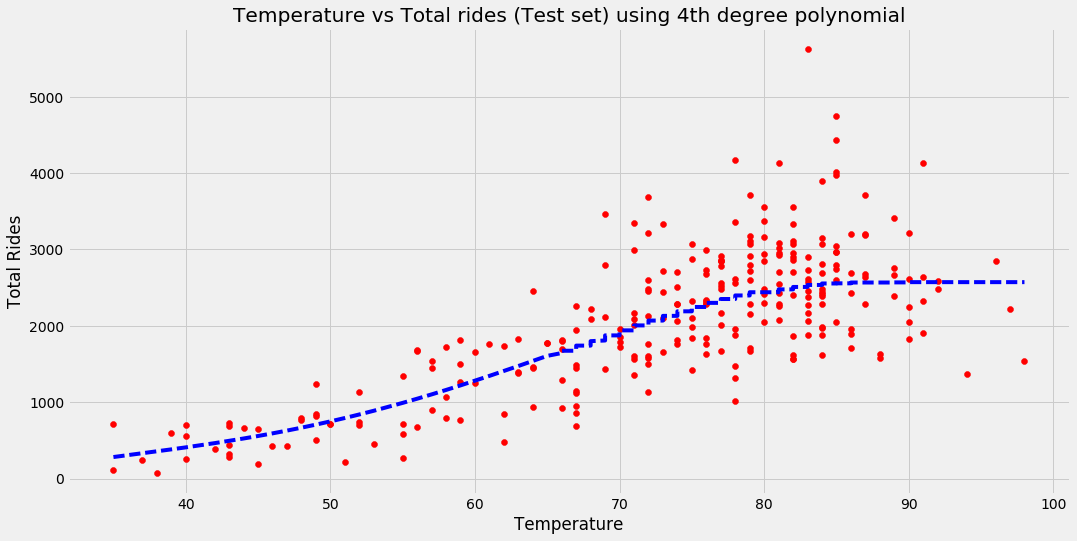

Explained Variance Score: 0.58262328817
Mean Absolute Error 460.343014195
Root Mean Squared Error 616.576451703
R Squared Score 0.574521382938


In [17]:
# Extracting polynomial features
poly = PolynomialFeatures(degree=4)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)


# Create regressor using linear regression
regressor = LinearRegression()

# Training our model
regressor.fit(X_train_poly, y_train)

# Predicting values using our trained model
y_pred = regressor.predict(X_test_poly)

# Let's see how well the model does against our test data.
plt.figure(figsize=[16,8])
plt.scatter(X_test, y_test, color = 'red')
plt.plot(sorted(X_test), sorted(y_pred), '--',color = 'blue')

plt.title('Temperature vs Total rides (Test set) using 4th degree polynomial')
plt.xlabel('Temperature')
plt.ylabel('Total Rides')
plt.show()

ex_var_score = explained_variance_score(y_test, y_pred)
m_absolute_error = mean_absolute_error(y_test, y_pred)
m_squared_error = mean_squared_error(y_test, y_pred)
r_2_score = r2_score(y_test, y_pred)

print("Explained Variance Score: "+str(ex_var_score))
print("Mean Absolute Error "+str(m_absolute_error))
print("Root Mean Squared Error "+str(np.sqrt(m_squared_error)))
print("R Squared Score "+str(r_2_score))

# These are the benchmarks to beat for future models:
* Explained Variance Score: 0.5826
* Mean Absolute Error 460.3430
* Root Mean Squared Error 616.5765
* R Squared Score 0.5745

## Sidenotes on benmarks:
* 0th degree polynomial benchmarks are:
 * Explained Variance Score: 0.0000
 * Mean Absolute Error 774.0123
 * Root Mean Squared Error 962.5057
 * R Squared Score -0.0368
* Linear regression benchmarks are:
 * Explained Variance Score: 0.5307
 * Mean Absolute Error 490.8600
 * Root Mean Squared Error 653.9021
 * R Squared Score 0.5214
 
# Percent improved from linear to 4th degree polynomial:
 * Explained Variance Score: 9.78%
 * Mean Absolute Error 6.22%
 * Root Mean Squared Error 5.71%
 * R Squared Score 10.18%